# Train a Cats-vs-dogs Recognizer with CNN model

In [3]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

## Download

If the URL for download doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765 and right click on the 'Download Manually' link to get a new URL to the dataset.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

## Preprocessing
First, create a directory "tmp/PetImages" containing subdirectories called 'Cat' and 'Dog'.

Next, create folder "tmp/cats-v-dogs" and split data for training and testing with the ratio of 90-10, since the data size is more than 10,000.

In [4]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

In [6]:
try:
    os.mkdir("/tmp/cats-v-dogs")
    os.mkdir("/tmp/cats-v-dogs/training")
    os.mkdir("/tmp/cats-v-dogs/training/cats")
    os.mkdir("/tmp/cats-v-dogs/training/dogs")
    os.mkdir("/tmp/cats-v-dogs/testing")
    os.mkdir("/tmp/cats-v-dogs/testing/cats")
    os.mkdir("/tmp/cats-v-dogs/testing/dogs")
except OSError:
    pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
# Expected Output:
# 666.jpg is zero length, so ignoring.
# 11702.jpg is zero length, so ignoring.

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [8]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
# Expected Output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


## Definition

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [57]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18496)           

In [41]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Training

In [30]:
history = model.fit(train_generator, 
                    epochs=40, 
                    steps_per_epoch=90,
                    validation_data=validation_generator, 
                    validation_steps=6)

Epoch 1/40
26/90 [=======>......................] - ETA: 42s - loss: 2.7188 - acc: 0.4896

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 66s 721ms/step - loss: 1.5251 - acc: 0.5270 - val_loss: 0.6523 - val_acc: 0.6860
Epoch 2/40
90/90 [==============================] - 64s 710ms/step - loss: 0.6366 - acc: 0.6541 - val_loss: 0.5425 - val_acc: 0.7247
Epoch 3/40
90/90 [==============================] - 64s 707ms/step - loss: 0.5641 - acc: 0.7068 - val_loss: 0.5711 - val_acc: 0.7040
Epoch 4/40
90/90 [==============================] - 63s 705ms/step - loss: 0.5041 - acc: 0.7542 - val_loss: 0.4553 - val_acc: 0.7760
Epoch 5/40
90/90 [==============================] - 63s 701ms/step - loss: 0.4628 - acc: 0.7777 - val_loss: 0.5098 - val_acc: 0.7567
Epoch 6/40
90/90 [==============================] - 63s 704ms/step - loss: 0.4179 - acc: 0.8083 - val_loss: 0.4207 - val_acc: 0.7973
Epoch 7/40
90/90 [==============================] - 63s 703ms/step - loss: 0.3677 - acc: 0.8342 - val_loss: 0.4653 - val_acc: 0.7847
Epoch 8/40
90/90 [==============================] - 63s 700ms/step - loss: 0.336

## Performance

<Figure size 432x288 with 0 Axes>

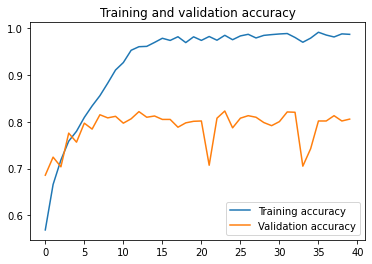

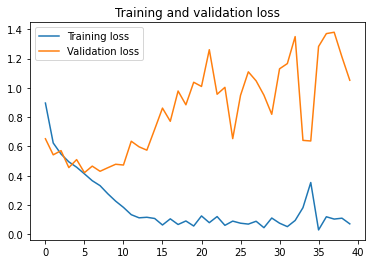

<Figure size 432x288 with 0 Axes>

In [31]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training accuracy' )
plt.plot  ( epochs, val_acc, label='Validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )
plt.legend(loc=0)
plt.figure()

## Overfitting

Note with a large dataset of diversity, Data Augmentation won't help much. In stead, we use "Dropout" to improve the Validation accuracy from 82% to 85%.

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dropout(0.65),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [56]:
history = model.fit(train_generator, 
                    epochs=40, 
                    steps_per_epoch=90,
                    validation_data=validation_generator, 
                    validation_steps=6)

Epoch 1/40
73/90 [=======================>......] - ETA: 11s - loss: 0.9027 - acc: 0.5432

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 65s 719ms/step - loss: 0.8687 - acc: 0.5510 - val_loss: 0.6105 - val_acc: 0.6827
Epoch 2/40
90/90 [==============================] - 64s 710ms/step - loss: 0.5949 - acc: 0.6796 - val_loss: 0.5269 - val_acc: 0.7393
Epoch 3/40
90/90 [==============================] - 64s 715ms/step - loss: 0.5290 - acc: 0.7381 - val_loss: 0.4831 - val_acc: 0.7707
Epoch 4/40
90/90 [==============================] - 64s 714ms/step - loss: 0.4913 - acc: 0.7604 - val_loss: 0.4832 - val_acc: 0.7733
Epoch 5/40
90/90 [==============================] - 64s 713ms/step - loss: 0.4530 - acc: 0.7835 - val_loss: 0.4646 - val_acc: 0.7840
Epoch 6/40
90/90 [==============================] - 64s 713ms/step - loss: 0.4238 - acc: 0.8065 - val_loss: 0.4235 - val_acc: 0.8007
Epoch 7/40
90/90 [==============================] - 64s 713ms/step - loss: 0.3968 - acc: 0.8192 - val_loss: 0.4040 - val_acc: 0.8147
Epoch 8/40
90/90 [==============================] - 64s 713ms/step - loss: 0.372

<Figure size 432x288 with 0 Axes>

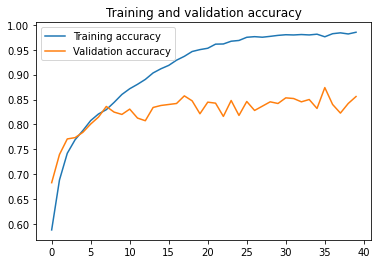

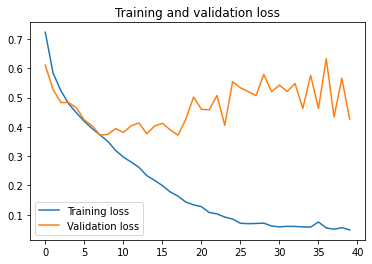

<Figure size 432x288 with 0 Axes>

In [58]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training accuracy' )
plt.plot  ( epochs, val_acc, label='Validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )
plt.legend(loc=0)
plt.figure()

## Visualization

In [51]:
train_cats_dir = TRAINING_CATS_DIR
train_dogs_dir = TRAINING_DOGS_DIR

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['10663.jpg', '12462.jpg', '2674.jpg', '10070.jpg', '8843.jpg', '4599.jpg', '8770.jpg', '5929.jpg', '4268.jpg', '2444.jpg']
['10663.jpg', '2674.jpg', '10070.jpg', '8843.jpg', '8770.jpg', '5929.jpg', '4268.jpg', '2444.jpg', '8325.jpg', '11196.jpg']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


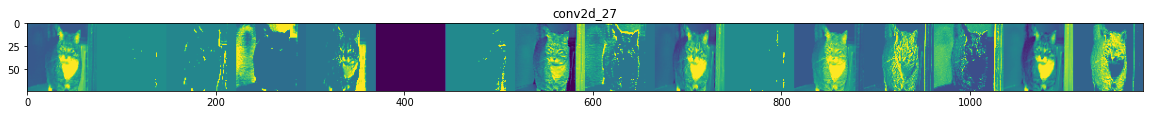

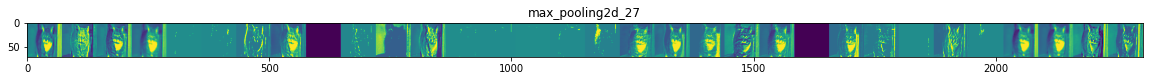

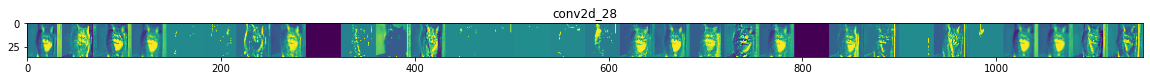

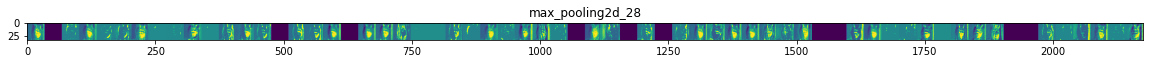

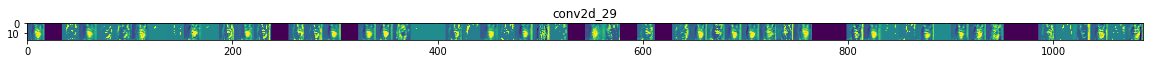

In [54]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## Prediction

In [ ]:
# Upload an image here and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")